# 1 Motivation


Creating embeddings is one of the classic tasks of Deep Learning. It is quite relevant to do this for graphs, since this is a complex data structure that cannot be analyzed in many standard ways. In this notebook, I want to show how we can create embeddings for data presented as a graph, as well as how these embeddings can be used

In one of my last projects (https://github.com/AlgazinovAleksandr/My_projects/blob/main/Communities%20of%20Faculties.ipynb), I have analyzed the subjects that are taught at different faculties of the Higher School of Economics. As a result, I not only conducted a graph analysis of the data, but also identified communities (clusters) based on various algorithms. At the same time, I did not use classical Machine Learning instuments, which can be very useful in the context of analysis. They, on the one hand, expand our tools, and, on the other, allow us to solve completely new problems

**Note that the analysis of this dataset originally comes from my university project, which was written in Russian. That is why, the text in the dataset, hence, in the graph, is not in English. At the same time, I am sure that this will not cause misunderstandings when studying the project itself, since I will still explain each step**

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import networkx.algorithms.community as nxcom
from matplotlib import pyplot as plt
import community as community_louvain
import matplotlib.cm as cm
from node2vec import Node2Vec

# 2 Data

### 2.1 Dataset description

The data shows which subjects are taught in the first year of various HSE faculties. Dataset consists of sources (faculties), and targets (subjects). This is sufficient to construct a graph and to work with it. All in all, we have 125 observations, 11 faculties, and 57 subjects

In [3]:
df = pd.read_excel('embeddings_on_graph.xlsx')
df

,source,target
0,МИЭМ (ИВТ),нез оценка по цифр грамотности
1,МИЭМ (ИВТ),история
2,МИЭМ (ИВТ),физика
3,МИЭМ (ИВТ),матан
4,МИЭМ (ИВТ),алгебра
...,...,...
120,ШИЯ,второй язык
121,ШИЯ,языкознание
122,ШИЯ,литература США
123,ШИЯ,культура работы с данными


### 2.2 Data visualization

Now we will construct a graph from our table. An edge between two nodes exists if their dependence is represented in the dataframe

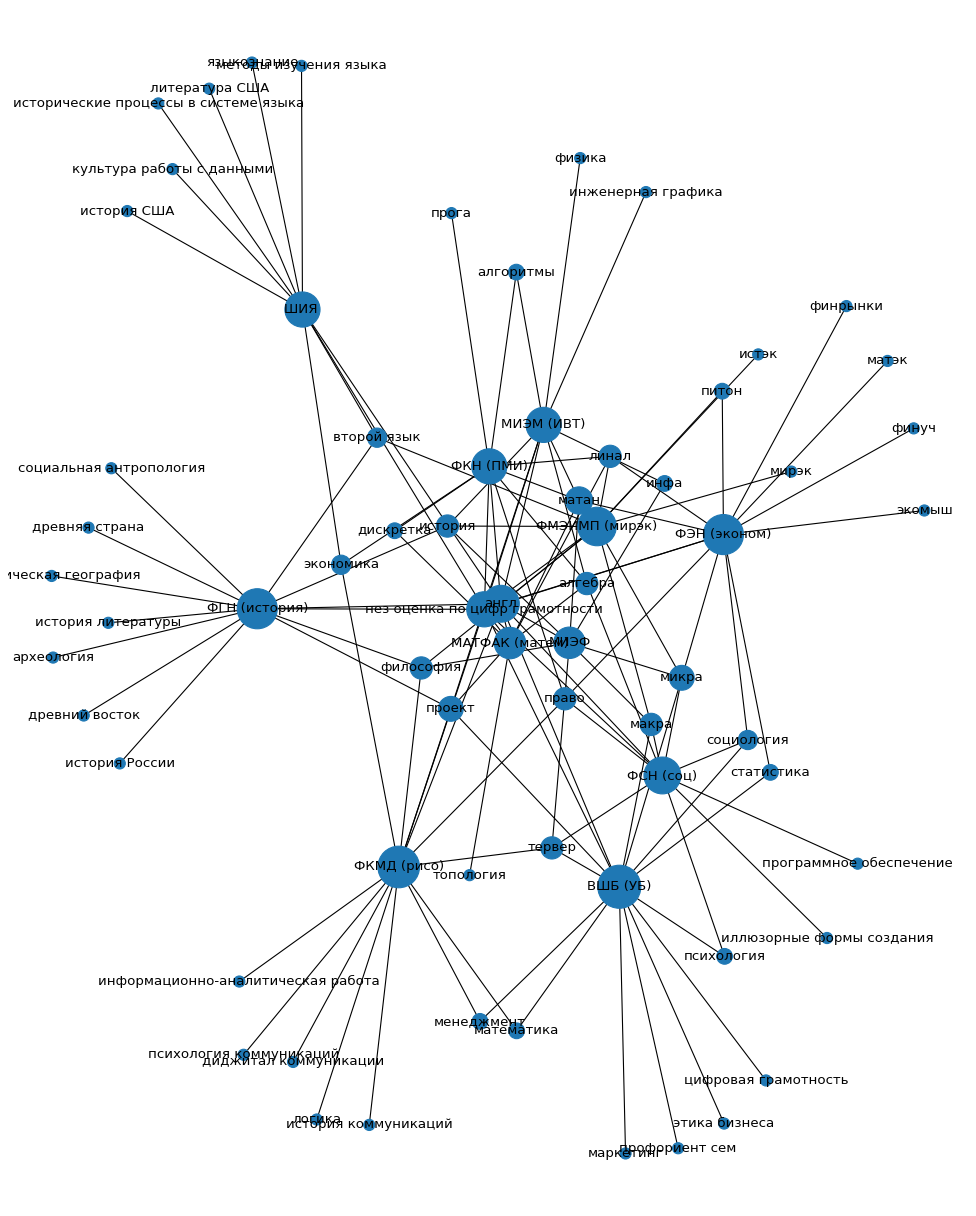

In [4]:
from matplotlib.pyplot import figure
figure(figsize=(12, 15), dpi=80)
Graphtype = nx.Graph()
G = nx.from_pandas_edgelist(df, create_using=Graphtype)
d = dict(G.degree)
nx.draw(G, nodelist=d.keys(), node_size=[v * 100 for v in d.values()], with_labels=True)
plt.show()

# 3 Graph embeddings

### 3.1 Node2Vec algorithm

Suppose we have a graph $G = (V, E)$, where $V = \{v_i\}_{i=1}^{|V|}$ stands for nodes, and $E$ represents edges with nonzero weights. Let $s_g(v_i, v_j)$ represent a similarity function between two nodes. In Node2Vec algorithm, we use conditional probability of moving from one node to another ($p(v_j | v_i)$) as a similarity function, and we estimate it using random walk. As usually, we want to map our nodes to fixed length vectors, and we will have a special encoder, which does this: $\text{ENC}: V \rightarrow R^d$, $\text{ENC}(v_i) = z_i$. Since there are too many possible options to create an embedding, we want to choose the best, or at least a satisfying one. Therefore, we will check if a decoder of two embeddings returns a value, close to initially estimated probability $\Rightarrow \text{DEC}(z_i, z_j) \approx p(v_j | v_i)$. So, in general this is a minimization function that looks like this:

$$\sum_{v_i, v_j \in V}\ell\Bigl(\text{DEC}[\text{ENC}(v_i), \text{ENC}(v_j)], s_g(v_i, v_j)\Bigl) \longrightarrow \min_{\text{ENC}, \text{DEC}}.$$

We will define a decoder as a Softmax operator of the dot product of vectors, and after that we will get an important rule:

$$p(v_j | v_i) \approx \frac{e^{z_j^Tz_i}}{\sum_{k}e^{z_k^Tz_i}} = \text{DEC}(z_i, z_j).$$

As a loss function, we will use:

$$\ell = \sum_{(v_i, v_j)}-log(\text{DEC}(z_i, z_j)).$$

### 3.2 Create embeddings

Now we will use a Python library to create embeddings. Since we have a relatively small graph, we will not make high-dimensional vectors, and we can have a big number of walks

In [8]:
node2vec = Node2Vec(G, dimensions=16, walk_length=10, num_walks=600, workers=4)

# Embed nodes
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Create embeddings
embeddings = model.wv.vectors

# 4 Applications, analysis, and modelling

Note: in this section, my goal was to consider ideas and examples of tasks in which graph data and the Node2Vec algorithm can be used, rather than getting good and practical results

### 4.1 Recommendations

Given a particular node, we can find most similar nodes to it. This can be used in social network analysis, where communication between people is very easily represented as a graph. So, based on information about you and your friends, algorithm can and will recommend you new ones

In our case, we can choose a particular faculty, and see, which subjects are most likely to be taught there. As a result, we can recommend a new subject, or suggest some changes in program (if there are some subjects that do not really fit the faculty) 

In [9]:
# Look for most similar nodes for faculty of Electronics and Mechanics
model.wv.most_similar('МИЭМ (ИВТ)')

[('физика', 0.8528711795806885),
 ('инженерная графика', 0.8527700901031494),
 ('алгоритмы', 0.7580235004425049),
 ('инфа', 0.703157365322113),
 ('история', 0.5923522114753723),
 ('алгебра', 0.5633479952812195),
 ('матан', 0.5592852234840393),
 ('ФКН (ПМИ)', 0.538851261138916),
 ('МАТФАК (матем)', 0.499024897813797),
 ('дискретка', 0.48661258816719055)]

In [10]:
# check which subjects are taught there
df.loc[df['source'] == 'МИЭМ (ИВТ)']

,source,target
0,МИЭМ (ИВТ),нез оценка по цифр грамотности
1,МИЭМ (ИВТ),история
2,МИЭМ (ИВТ),физика
3,МИЭМ (ИВТ),матан
4,МИЭМ (ИВТ),алгебра
5,МИЭМ (ИВТ),инфа
6,МИЭМ (ИВТ),инженерная графика
7,МИЭМ (ИВТ),проект
8,МИЭМ (ИВТ),англ
9,МИЭМ (ИВТ),алгоритмы


As we see, discrete maths is not being taught there on the first year of studies, but the subjects seems to be fitting the program. At the same time, we see that faculty is similar to faculty of Computer Science and Mathematics, so the method can be seen as one more approach for commuity detection (ot clustering) problem

### 4.2 Classification

The great thing about embeddings is that we can fit them to AI models. Thus, embeddings often act as an object that allows models to learn from complex non-tabular data structures, which makes neural networks a truly indispensable tool in many Data Science projects

Here we will do a binary classification problem. Again, the goal is just to show it works, not to make a discovery, or at least to get a good model. So, we will say that target variable is equal to 1, if it is a subject that we came across at least 3 times, or if it is a faculty (0 otherwise)

In [ ]:
popular = df.groupby('target').count().reset_index()
popular = popular.loc[popular['source'] >= 3]
popular_subjects = popular['target'].tolist()
popular_subjects

faculties = list(set(df['source'].tolist()))
faculties

In [99]:
nodes = d.keys()
nodes = pd.DataFrame(nodes)
nodes.columns = ['node']
nodes['target'] = 0
nodes.loc[nodes['node'].isin(popular_subjects), 'target'] = 1
nodes.loc[nodes['node'].isin(faculties), 'target'] = 1
y = nodes['target']

Now, when we have embeddings and targets, we can divide the sample into training and test, and train several models. We will compare models with ROC-AUC metric 

##### 4.2.1 Logistic Regression

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.15, random_state=42, stratify=y)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(y_pred)
roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])

[0 0 0 0 1 0 0 0 1 0 0]


0.6071428571428572

In [103]:
y_test

4     1
40    0
20    0
9     1
32    1
52    0
64    0
30    0
13    1
45    0
42    0
Name: target, dtype: int64

We see that the dataset is imbalanced, and we mostly predict 0 target. Logistic Regression was right in both cases it predict target 1. At the same time, it seems to be very careful, and most likely to predict 0, even if it looks like 1

##### 4.2.2 CatBoost

In [104]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(verbose=False).fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred

roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

0.7142857142857143

The metric increased, i.e if we find a good threshold, the model is likely to make better predictions, than Logistic Regression

##### 4.2.3 Introduce class weight

Since the dataset is imbalanced, it makes sense to penalize incorrectly classified objects of class 1 more. Because otherwise the model has a greater incentive to predict the value of 0, since it is simply more likely to correctly guess the object. We saw this case with Logistic Regression

In [107]:
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

clf = CatBoostClassifier(class_weights=class_weights, verbose=False)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred

roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

0.75

So far, this is the best model (based on ROC-AUC on test set metric)

# References

https://github.com/AlgazinovAleksandr/My_projects/blob/main/Communities%20of%20Faculties.ipynb - my previous project, on the basis of which this jupyter notebook is made

https://github.com/eliorc/node2vec - guide from the creators of the node2vec Python library

https://www.kaggle.com/code/shakshisharma/graph-embeddings-deepwalk-and-node2vec/notebook - motivation, and another example of how embeddings on graphs can be used to solve Machine Learning problems

https://github.com/esokolov/ml-course-hse/blob/master/2021-spring/seminars/sem17-graph.pdf - theory behind Node2Vec, as well as explanation of the algorithm

